# House Prices : Advance Regression Techniques

## Imports

In [1]:
%matplotlib inline

import math, time, random, datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

import catboost
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

import warnings
warnings.filterwarnings('ignore')

## Loading the Data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample = pd.read_csv('data/sample_submission.csv')

In [3]:
train.shape

(1460, 81)

In [4]:
test.shape

(1459, 80)

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [7]:
sample.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


## Data Descriptions

In [8]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [9]:
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [10]:
train.SalePrice.skew()

1.8828757597682129

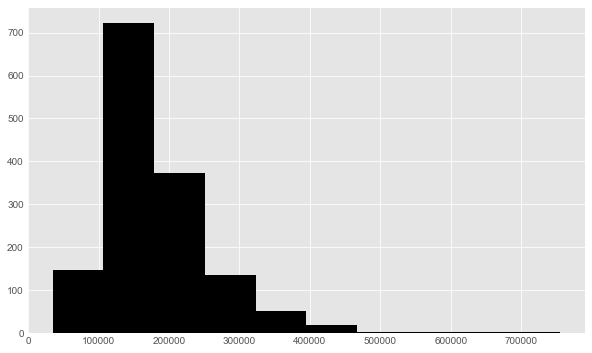

In [11]:
plt.hist(train.SalePrice, color= 'black')
plt.show()

positively skewed

In [12]:
# log-transforming the data to improve linearity of the data
target = np.log(train.SalePrice)

In [13]:
target.skew()

0.12133506220520406

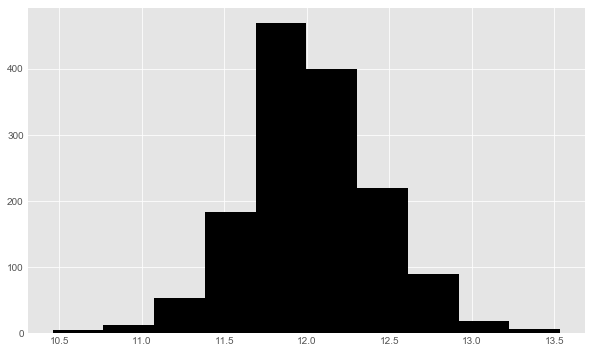

In [14]:
plt.hist(target, color='black')
plt.show()

normal distribution

## Feature Engineering

Correlation

In [15]:
numeric_features = train.select_dtypes(include=[np.number])
corr = numeric_features.corr()

In [20]:
corr['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

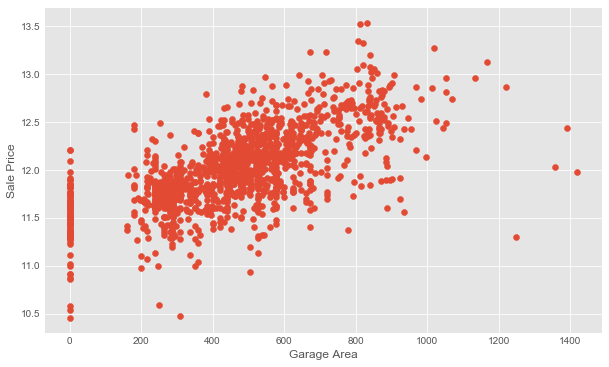

In [23]:
# hadling outliers
plt.scatter(x=train['GarageArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

In [24]:
train = train[train['GarageArea'] < 1200]

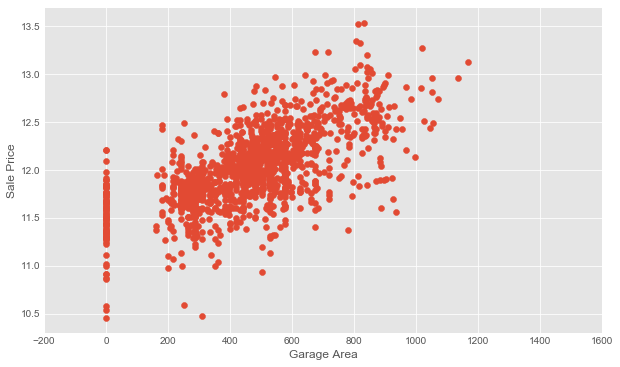

In [28]:
plt.scatter(x=train['GarageArea'], y=np.log(train.SalePrice))
plt.xlim(-200, 1600)
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

In [30]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False))
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls.head(25)

,Null Count
Feature,
PoolQC,1449
MiscFeature,1402
Alley,1364
Fence,1174
FireplaceQu,689
LotFrontage,258
GarageCond,81
GarageType,81
GarageYrBlt,81


In [31]:
categoricals = train.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1455,1455,91,1455,1455,1455,1455,1455,1455,1455,...,1374,1374,1374,1374,1455,6,281,53,1455,1455
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1147,1450,50,921,1309,1454,1048,1378,225,1257,...,867,605,1306,1321,1335,2,157,48,1266,1196


In [32]:
train.Street.value_counts()

Pave    1450
Grvl       5
Name: Street, dtype: int64

In [33]:
train['enc_street'] = pd.get_dummies(train.Street, drop_first=True)
test['enc_street'] = pd.get_dummies(test.Street, drop_first=True)

In [36]:
train.enc_street.value_counts()

1    1450
0       5
Name: enc_street, dtype: int64

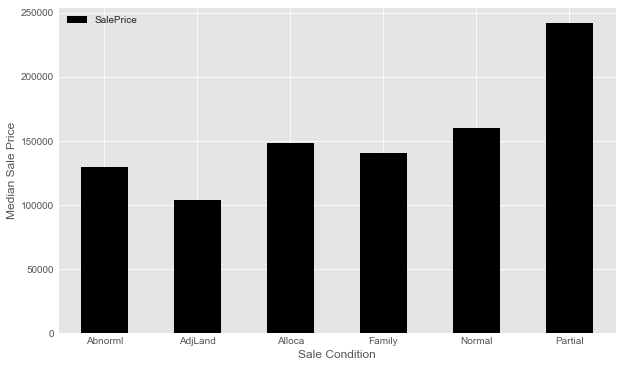

In [37]:
condition_pivot = train.pivot_table(index= 'SaleCondition',
                                    values= 'SalePrice',
                                    aggfunc= np.median)
condition_pivot.plot(kind= 'bar', 
                     color= 'black')
plt.xlabel('Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation = 0)
plt.show()

In [39]:
def encode(x):
    return 1 if x == 'Partial' else 0

train['enc_condition'] = train.SaleCondition.apply(encode)
test['enc_condition'] = test.SaleCondition.apply(encode)

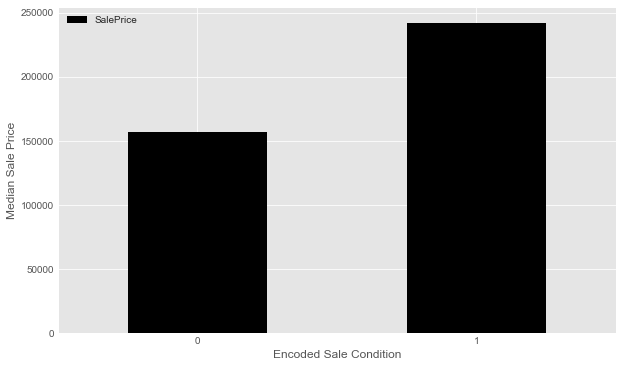

In [41]:
condition_pivot = train.pivot_table(index= 'enc_condition',
                                    values= 'SalePrice',
                                    aggfunc= np.median)
condition_pivot.plot(kind= 'bar', 
                     color= 'black')
plt.xlabel('Encoded Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation = 0)
plt.show()

In [42]:
data = train.select_dtypes(include= [np.number]).interpolate().dropna()

In [44]:
data.isnull().sum().value_counts()

0    40
dtype: int64

In [48]:
len(data.columns)

40

## Model Building

In [49]:
y = np.log(train.SalePrice)
X = data.drop(['SalePrice', 'Id'], axis= 1)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, test_size= 0.2)

In [51]:
# Linear Regression
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

In [52]:
'R^2 value is {}'.format(model.score(X_test, y_test))

'R^2 value is 0.8902598100811375'

In [76]:
predictions = model.predict(X_test)

In [54]:
# RMSE Root mean squared error
'RMSE is {}'.format(mean_squared_error(y_test, predictions))

'RMSE is 0.016980618376556386'

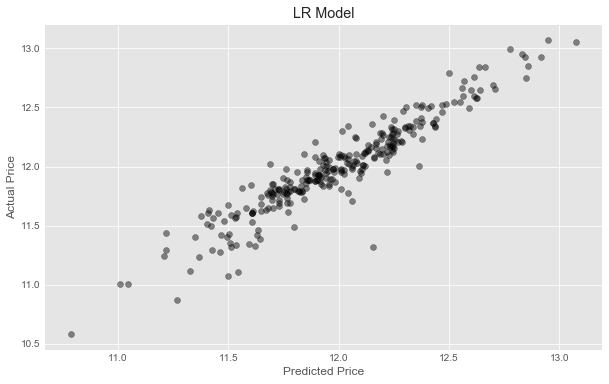

In [58]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha= 0.45, color= 'black')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('LR Model')
plt.show()

graph close to y = x means that predicted values are equal to actual values

## Improve the Model

**Ridge Regularization**

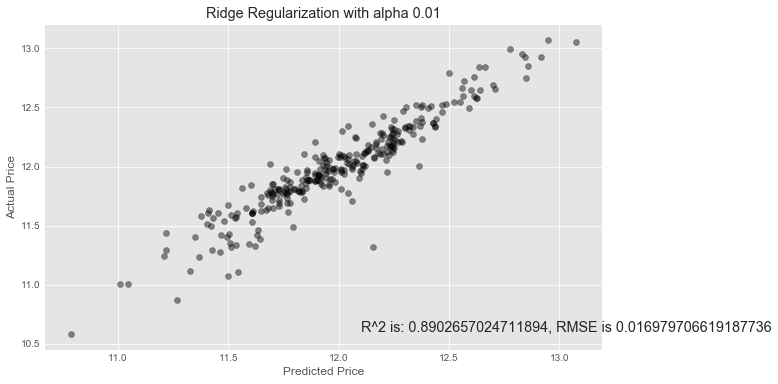

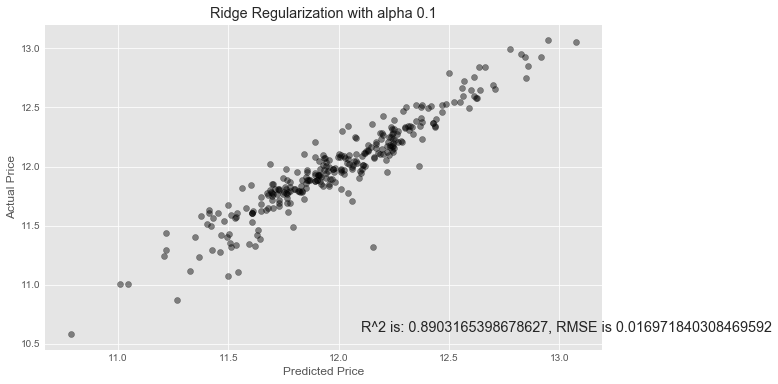

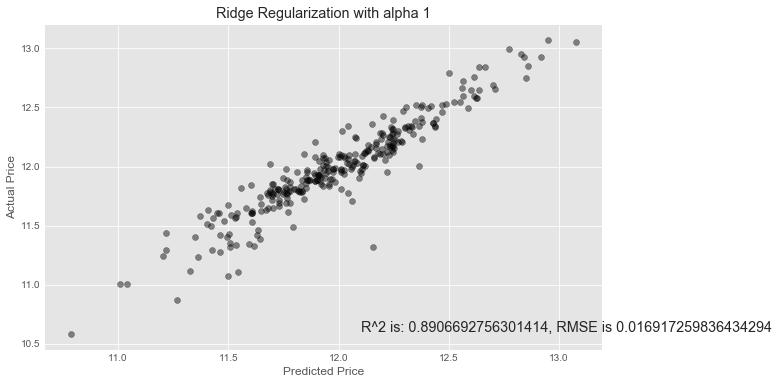

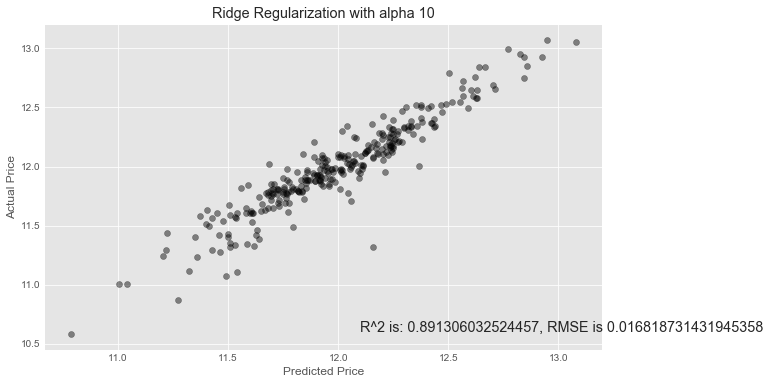

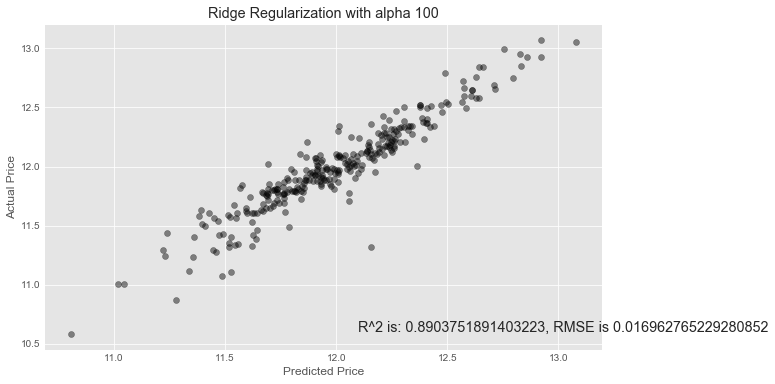

In [60]:
for i in range(-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)
    
    plt.scatter(preds_ridge, actual_values, alpha=0.45, color='black')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Ridge Regularization with alpha {}'.format(alpha))
    overlay = 'R^2 is: {}, RMSE is {}'.format(ridge_model.score(X_test, y_test),
                                             mean_squared_error(y_test, preds_ridge))
    plt.annotate(s=overlay, xy= (12.1, 10.6), size= 'x-large')
    plt.show()

## Submitting

In [85]:
submission = pd.DataFrame()
submission['Id'] = test.Id

In [86]:
feats = test.select_dtypes(include= [np.number]).drop(['Id'], axis= 1).interpolate()

In [87]:
predictions = model.predict(feats)

In [88]:
# we have taken log previously 
# now we are exponetiate it
final_predictions = np.exp(predictions)

In [89]:
predictions[:3]

array([11.75033689, 11.91033345, 12.08105142])

In [90]:
final_predictions[:3]

array([126796.26757593, 148796.28693378, 176495.6338042 ])

In [91]:
len(final_predictions)

1459

In [92]:
submission['SalePrice'] = final_predictions

In [93]:
submission.head()

,Id,SalePrice
0,1461,126796.267576
1,1462,148796.286934
2,1463,176495.633804
3,1464,200447.123969
4,1465,180996.765481


In [94]:
sample.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [95]:
submission.to_csv('submission.csv', index= False)